# 2-Point Correlation Function (2PCF) analysis 

In this notebook we perform the main analysis using 2PCFs in pregnant women at ANC visits and children from cross-sectional surveys. 

## Importing modules and functions

In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from spatial_tools import clustering, visualise
from stat_tools import errors
import contextily as ctx
from pregmal_pytools import spatial_utils
from stat_tools import stats
import scipy.stats as sci_stats
from time import time

## Importing data 

In [2]:
mipmon, cross, cross210 = spatial_utils.import_spatial_data(serology_name = None)

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/spatial_utils.py:290: Se

## Define masks and other definitions

In [3]:
#MiPMon masks
has_geo_mip = mipmon['latitude'].notnull()&mipmon['longitude'].notnull()
has_pcr_mip = mipmon['pcrpos'].notnull()&has_geo_mip
mip_pcrpos = mipmon['pcrpos'] == 1
mip_pcrneg = mipmon['pcrpos'] == 0
mip_rdtpos = mipmon['density'] >= 100
mip_rdtneg = mipmon['density'] < 100
prenatal = (mipmon['visit'] == 'PN')&has_pcr_mip

#Define masks for MiPMon data
mipmon_pn = prenatal&has_pcr_mip
mipmon_pg = mipmon_pn&(mipmon['gestnum'] == 1)
mipmon_sg = mipmon_pn&(mipmon['gestnum'] == 2)
mipmon_12g = mipmon_pn&(mipmon['gestnum'] <= 2)
mipmon_mg = mipmon_pn&(mipmon['gestnum'] > 1)
mipmon_3g = mipmon_pn&(mipmon['gestnum'] > 2)
mipmon_hiv_pos = mipmon_pn&(mipmon['hiv'] == 'HIV+')
mipmon_hiv_neg = mipmon_pn&(mipmon['hiv'] == 'HIV-')
mipmon_pg_hiv_pos = mipmon_pg&mipmon_hiv_pos
mipmon_pg_hiv_neg = mipmon_pg&mipmon_hiv_neg

mipmon_selection = {
    'ANC (all)' : mipmon_pn,
    'ANC (PG)' : mipmon_pg,
    #'Secundigravid' : mipmon_sg,
    #'1-2gravid' : mipmon_12g,
    #'>2gravid' : mipmon_3g,
    'ANC (MG)' : mipmon_mg,
    'ANC (HIV+)' : mipmon_hiv_pos,
    'ANC (HIV-)' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    'ANC (PG HIV-)' : mipmon_pg_hiv_neg,
}

#Cross masks
cross210_area_mask = (cross210['area'] == 'Magude Sede')|(cross210['area'] == 'Manhiça')|(cross210['area'] == 'Ilha Josina')
cross210_area_mask = cross210_area_mask | (cross210['area'] == 'Taninga')|(cross210['area'] == 'Panjane')
cross210_area_mask = cross210_area_mask |(cross210['area'] == 'Palmeira')
cross210_area_mask = cross210_area_mask | (cross210['area'] == 'Maragra')|(cross210['area'] == 'Malavele')
has_geo_cross = cross['lat'].notnull()&cross['lng'].notnull()
has_pcr_cross = cross['pospcr'].notnull()&has_geo_cross
has_rdt_cross = cross['rdt'].notnull()&has_geo_cross
cross_pcrpos = cross['pospcr'] == 1
cross_pcrneg = cross['pospcr'] == 0
cross_rdtpos = cross['rdt'] == 1
cross_rdtneg = cross['rdt'] == 0

has_geo_cross210 = cross210['lat'].notnull()&cross210['lng'].notnull()
has_pcr_cross210 = cross210['pospcr'].notnull()&has_geo_cross210
has_rdt_cross210 = cross210['rdt'].notnull()&has_geo_cross210
cross210_pcrpos = cross210['pospcr'] == 1
cross210_pcrneg = cross210['pospcr'] == 0
cross210_rdtpos = cross210['rdt'] == 1
cross210_rdtneg = cross210['rdt'] == 0


#Colour palette for MiPMon selections
colors_mipmon = [cm.turbo((i+1)/float(len(mipmon_selection) + 1)) for i in range(len(mipmon_selection) + 1)]

#years = [2017, 2018, 2019]
years = [1, 2, 3]

# Analysis 

### Chosen 2PCF parameters 

In [4]:
#Number of spatial bins
bins = 10
#Spatial range of scale in Km
ranges = [.0,60.]
#Number of random realisations
nrands = 20


### 2PCF measurements 
 

In [5]:
def get_2pcf_cross(dataframe, pcrpos, mask, bins, ranges, nrands, colour, \
                   get_error = True, show = True, lw = 2):
    #Defining input data from cross-sectional 2PCFs
    x1 = np.array(dataframe[mask&pcrpos]['lng'])
    y1 = np.array(dataframe[mask&pcrpos]['lat'])
    x2 = np.array(dataframe[mask]['lng'])
    y2 = np.array(dataframe[mask]['lat'])
    w1 = np.array(dataframe[mask&pcrpos]['weight'])
    w2 = np.array(dataframe[mask]['weight'])
    
    #Run 2PCF for cross-sectional
    cross_2pcf, mean_bin_cross, edges, cross_err = clustering.correlation_function(x1, y1, x2, y2, \
                                                                                bins = bins, \
                                                                                ranges = ranges, \
                                                                                get_error=get_error, \
                                                                                nrands = nrands, \
                                                                                w1 = w1, w2 = w2)
    #Plotting results for non-empty data
    mask_empty_bins = (cross_2pcf**2>=0)&(cross_err**2>=0)
    if show:
        plt.errorbar(mean_bin_cross[mask_empty_bins], cross_2pcf[mask_empty_bins], \
                     cross_err[mask_empty_bins], c = 'k', label = "Children 2-10", \
                    linestyle = '--', lw = lw)
    return cross_2pcf, mean_bin_cross, edges, cross_err

def get_2pcf_mipmon(dataframe, pcrpos, mask, bins, ranges, nrands, colour, \
                    get_error = True, show = True, label = '', mode = 'auto', \
                    cross_df = None, cross_pcrpos = None, cross_mask = None, \
                   lw = 2):
    #Defining input data from ANC 2PCFs
    x1 = np.array(dataframe[mask&pcrpos]['longitude'])
    y1 = np.array(dataframe[mask&pcrpos]['latitude'])
    x2 = np.array(dataframe[mask]['longitude'])
    y2 = np.array(dataframe[mask]['latitude'])
    w1 = None
    w2 = None
    if mode == 'cross':
        x1x = np.array(cross_df[cross_mask&cross_pcrpos]['lng'])
        y1x = np.array(cross_df[cross_mask&cross_pcrpos]['lat'])
        x2x = np.array(cross_df[cross_mask]['lng'])
        y2x = np.array(cross_df[cross_mask]['lat'])
        w1x = np.array(cross_df[cross_mask&cross_pcrpos]['weight'])
        w2x = np.array(cross_df[cross_mask]['weight'])
    elif mode == 'auto':
        x1x, y1x, x2x, y2x, w1x, w2x = None, None, None, None, None, None
    else:
        print("WARNING: invalid value of mode", mode, ", assuming auto")
        x1x, y1x, x2x, y2x, w1x, w2x = None, None, None, None, None, None
    
    #Run 2PCF for ANC
    mip_2pcf, mean_bin_mip, edges, \
    mip_err = clustering.correlation_function(x1, y1, x2, y2, \
                                              bins = bins, ranges = ranges, \
                                              get_error=get_error, \
                                              nrands = nrands, \
                                              w1 = w1, w2 = w2, \
                                              x1x = x1x, y1x = y1x, \
                                              x2x = x2x, y2x = y2x, w1x = w1x, w2x = w2x)
    #Plotting results for non-empty data
    mask_empty_bins = (mip_2pcf**2>=0)&(mip_err**2>=0)
    if show:
        plt.errorbar(mean_bin_mip[mask_empty_bins], mip_2pcf[mask_empty_bins], \
                     mip_err[mask_empty_bins], c = colour, label = label, lw = lw)
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_2pcf_mipmon_selections(dataframe, pcrpos, mipmon_selection, mask, bins, ranges, nrands, \
                               colours, get_error = True, show = True, mode = 'auto', \
                               cross_df = None, cross_pcrpos = None, cross_mask = None, \
                              lw = 2):
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    for c, s in enumerate(mipmon_selection):
        #Run 2PCF for ANC
        mip_2pcf[s], mean_bin_mip[s], edges[s], \
        mip_err[s] = get_2pcf_mipmon(dataframe, pcrpos, mask&mipmon_selection[s], \
                                             bins, ranges, get_error=get_error, nrands = nrands, \
                                             colour = colours[c], label = s, mode = mode, \
                                    cross_df = cross_df, cross_pcrpos = cross_pcrpos, \
                                     cross_mask = cross_mask, lw = lw)
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_all_2pcf_years(mipmon_df, mip_pcrpos, mipmon_selection, mip_mask, cross_df, cross_pcrpos, cross_mask, bins, \
                       ranges, nrands, colors_mipmon, colour_cross, get_error = True, show = True, verbose = False, \
                       time_width = None, mode = 'auto', ylims = [-1,3], ncol = 1, lw = 2, fontsize = None):
    #Dictionary to store results from ANC data
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    cross_2pcf, mean_bin_cross, edges, cross_err  = {}, {}, {}, {}
    
    for y in years:
        #Mask to select the year of the data
        #cross_mask_time = cross_df['year'] == y
        #mip_mask_time = mipmon_df['year'] == y
        cross_mask_time, mip_mask_time = get_time_masks(cross_df, mipmon_df, y, time_width = time_width)
        
        #Run 2PCF for all ANC selections
        if verbose:
            print('Sample size all 1st ANC:', np.sum(mip_mask_time&mip_mask))
        mip_2pcf[str(y)], mean_bin_mip[str(y)], edges[str(y)], mip_err[str(y)] = \
        get_2pcf_mipmon_selections(mipmon_df, mip_pcrpos, mipmon_selection, \
                                   mip_mask_time&mip_mask, bins, ranges, nrands, \
                                   colors_mipmon, get_error = get_error, show = show, \
                                   mode = mode, cross_df = cross_df, \
                                   cross_pcrpos = cross_pcrpos, \
                                   cross_mask = cross_mask_time&cross_mask, lw = lw)
        
        
        
        #Run 2PCF for cross-sectional
        if verbose:
            print('Sample size cross-sectional:', np.sum(cross_mask_time&cross_mask))
        cross_2pcf[str(y)], mean_bin_cross[str(y)], edges[str(y)], cross_err[str(y)] = \
        get_2pcf_cross(cross_df, cross_pcrpos, cross_mask_time&cross_mask, bins, \
                       ranges, nrands, colour_cross, get_error = get_error, show = show, \
                      lw = lw)
        
        
        plt.hlines(0, ranges[0] - 2, ranges[1] + 2, color = 'tab:grey')
        plt.xlim(ranges[0] - 2, ranges[1] + 2)
        #plt.legend(ncol = ncol, fontsize = fontsize, framealpha = 1)
        plt.xlabel('r (Km)', fontsize = fontsize)
        plt.ylabel(r'$\xi(r)$ year '+ str(y), fontsize = fontsize)
        #plt.title("2PCF year "+ str(y))
        plt.yticks(fontsize = fontsize)
        plt.xticks(fontsize = fontsize)
        plt.ylim(ylims)
        plt.show()
    return mip_2pcf, mean_bin_mip, edges, mip_err, cross_2pcf, mean_bin_cross, edges, cross_err

def get_time_masks(cross_df, mipmon_df, year, time_width = None, verbose = False):
    #Mask to select the year of the data
    cross_mask = cross_df['year'] == year
    if verbose:
        print('Sample size cross-sectional:', np.sum(cross_mask))
    if time_width is None:
        mip_mask = mipmon_df['year'] == year
    else:
        mean_cross_data = cross_df['visdate'][cross_mask].mean()
        mip_mask = get_time_mask_mipmon(mipmon_df, mean_cross_data, time_width, verbose = verbose)
    return cross_mask, mip_mask

def get_time_mask_mipmon(mipmon_df, date, time_width, verbose = True):
    #Selection a window aroung the cross-sectional data for ANC
    time_0 = date - pd.to_timedelta(time_width/2, unit = 'D')
    time_1 = date + pd.to_timedelta(time_width/2, unit = 'D')
    mip_mask = (mipmon_df['visdate'] >= time_0)&(mipmon_df['visdate'] <= time_1)
    if verbose:
        print('Sample size all 1st ANC:', np.sum(mip_mask))
    return mip_mask

### Using the whole year ANC data

In [6]:
mipmon_selection = {
    'All ANC visits' : mipmon_pn,
    'Primigravidae' : mipmon_pg,
    #'Secundigravid' : mipmon_sg,
    #'1-2gravid' : mipmon_12g,
    #'>2gravid' : mipmon_3g,
    'Multigravidae' : mipmon_mg,
    'HIV+' : mipmon_hiv_pos,
    'HIV-' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    'Primigravid HIV-' : mipmon_pg_hiv_neg,
}

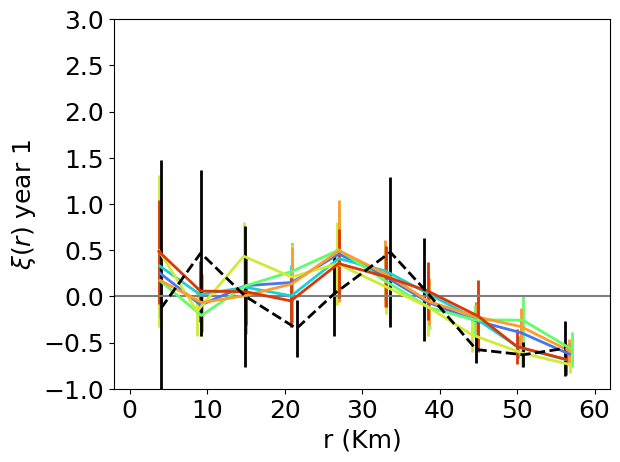

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide


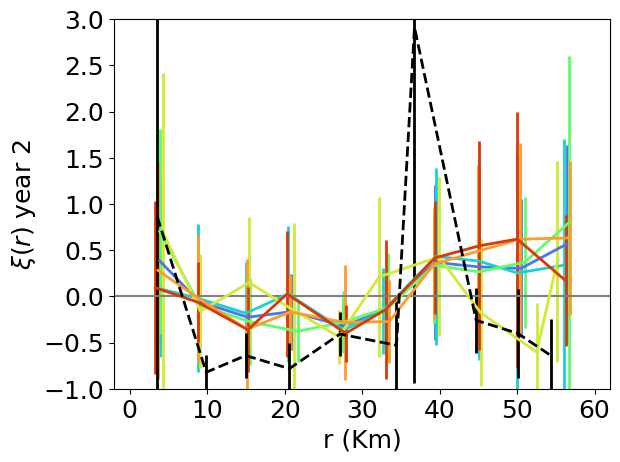

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-

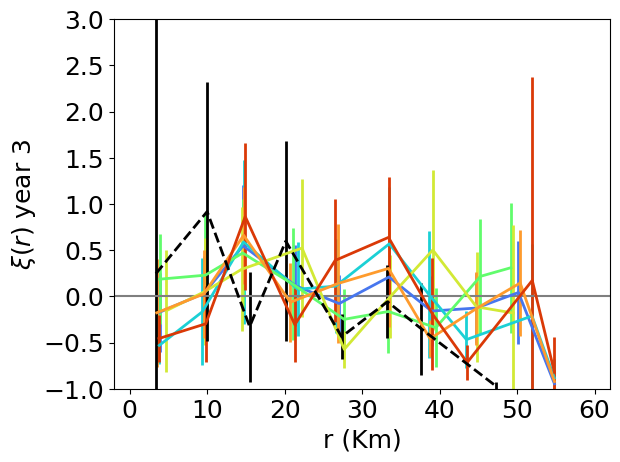

Time taken  126.73151326179504  seconds ( 2 minutes)


In [7]:
#Using RDT results, cross-correlation
start = time()
mip_2pcf_y_rdt_x, mean_bin_mip_y_rdt_x, edges_y_rdt_x, mip_err_y_rdt_x, cross_2pcf_rdt_x, mean_bin_cross_rdt_x, edges_x, cross_err_rdt_x = \
get_all_2pcf_years(mipmon, mip_rdtpos, mipmon_selection, prenatal, cross210, cross210_rdtpos, \
                   has_pcr_cross210&cross210_area_mask, bins, ranges, nrands, colors_mipmon, 'k', \
                   mode = 'cross', lw = 2, fontsize = 18)
end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

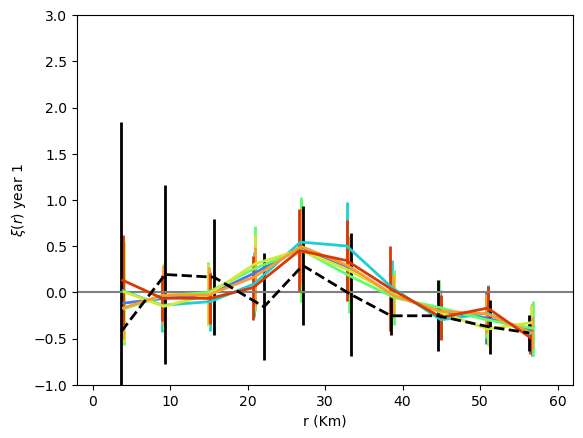

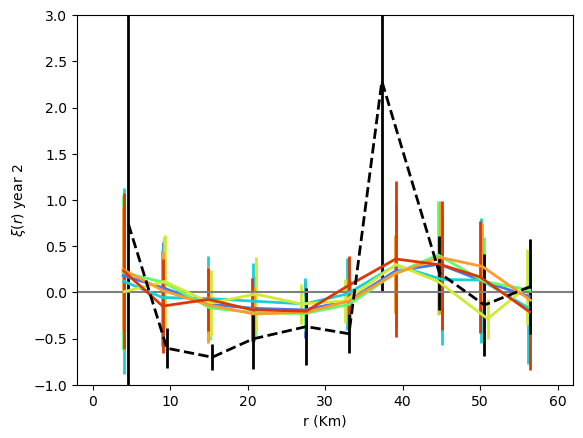

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide


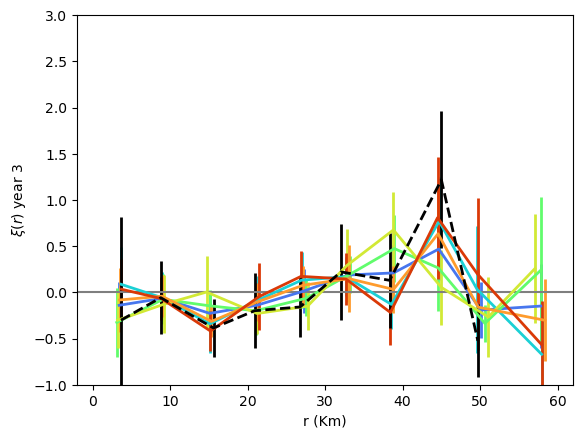

Time taken  135.2623062133789  seconds ( 2 minutes)


In [8]:
#Using PCR results, cross-correlation
start = time()
mip_2pcf_y_x, mean_bin_mip_y_x, edges_y_x, mip_err_y_x, cross_2pcf_x, mean_bin_cross_x, edges_x, cross_err_x = \
get_all_2pcf_years(mipmon, mip_pcrpos, mipmon_selection, prenatal, cross210, cross210_pcrpos, \
                   has_pcr_cross210&cross210_area_mask, bins, ranges, nrands, colors_mipmon, 'k', \
                   mode = 'cross', lw = 2)
end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

### Consistency analysis:

$\chi²$ Statistics will be obtained comparing the 2PCF measurement in children with the different populations of pregnant women.

In [9]:
chi2_y_x = {}
for y in years:
    chi2_y_x[str(y)] = {}
    for s in mipmon_selection:
        mask = (cross_err_x[str(y)]**2 > 0)&(mip_err_y_x[str(y)][s]**2 > 0)
        chi2_y_x[str(y)][s] = errors.chi_square(cross_2pcf_x[str(y)][mask], cross_err_x[str(y)][mask], \
                                                mip_2pcf_y_x[str(y)][s][mask], mip_err_y_x[str(y)][s][mask])
chi2_y_x = pd.DataFrame(chi2_y_x)

In [10]:
chi2_y_x

,1,2,3
All ANC visits,0.127674,0.697830,0.189125
Primigravidae,0.178561,0.537899,0.174402
Multigravidae,0.093412,0.627022,0.241084
HIV+,0.166631,0.738604,0.380542
HIV-,0.133848,0.654977,0.152560
Primigravid HIV-,0.126023,0.696124,0.211499


In [11]:
chi2_y_rdt_x = {}
for y in years:
    chi2_y_rdt_x[str(y)] = {}
    for s in mipmon_selection:
        mask = (cross_err_rdt_x[str(y)]**2 > 0)&(mip_err_y_rdt_x[str(y)][s]**2 > 0)
        chi2_y_rdt_x[str(y)][s] = errors.chi_square(cross_2pcf_rdt_x[str(y)][mask], cross_err_rdt_x[str(y)][mask], \
                                                    mip_2pcf_y_rdt_x[str(y)][s][mask], mip_err_y_rdt_x[str(y)][s][mask])
chi2_y_rdt_x = pd.DataFrame(chi2_y_rdt_x)

In [12]:
chi2_y_rdt_x

,1,2,3
All ANC visits,0.515648,0.816944,0.946006
Primigravidae,0.299776,0.430004,0.741710
Multigravidae,0.707733,0.624139,0.638846
HIV+,0.359210,0.436642,0.477078
HIV-,0.589579,0.687943,0.965276
Primigravid HIV-,0.225335,0.663279,0.841075


###  Significance analysis:

A t-test will be used to measure the statistical significance of the clustering signal of the different populations by measuring the deviation of the 2PCFs from zero. A table will be created describing the p-values of each population and year to identify the most significant clustering structures found.

In [13]:
def chi22p(chi2, dof):
    """This method translates from chi square statistics
    to p-value to get statistical significancy.
    
    Parameters:
    -----------
    chi2: float
        Value of chi square
    dof: int
        Number of degrees of freedom
    
    Returns:
    --------
    p: float
        P-value of statistical significance of the difference
    """
    p = 1 - sci_stats.chi2.cdf(chi2, dof)
    return p

In [14]:
sig_y_x = {}
p_y_x = {}
for y in years:
    sig_y_x[str(y)] = {}
    p_y_x[str(y)] = {}
    for s in mipmon_selection:
        mask = mip_err_y_x[str(y)][s]**2 > 0
        sig_y_x[str(y)][s] = errors.chi_square(mip_2pcf_y_x[str(y)][s][mask], mip_err_y_x[str(y)][s][mask], \
                                             0*mip_2pcf_y_x[str(y)][s][mask], 0*mip_err_y_x[str(y)][s][mask])
        p_y_x[str(y)][s] = chi22p(sig_y_x[str(y)][s]*bins, bins)
sig_y_x = pd.DataFrame(sig_y_x)
p_y_x = pd.DataFrame(p_y_x)



sig_y_rdt_x = {}
p_y_rdt_x = {}
for y in years:
    sig_y_rdt_x[str(y)] = {}
    p_y_rdt_x[str(y)] = {}
    for s in mipmon_selection:
        mask = mip_err_y_rdt_x[str(y)][s]**2 > 0
        sig_y_rdt_x[str(y)][s] = errors.chi_square(mip_2pcf_y_rdt_x[str(y)][s][mask], mip_err_y_rdt_x[str(y)][s][mask], \
                                             0*mip_2pcf_y_rdt_x[str(y)][s][mask], 0*mip_err_y_rdt_x[str(y)][s][mask])
        p_y_rdt_x[str(y)][s] = chi22p(sig_y_rdt_x[str(y)][s]*bins, bins)
sig_y_rdt_x = pd.DataFrame(sig_y_rdt_x)
p_y_rdt_x = pd.DataFrame(p_y_rdt_x)

In [15]:
p_y_x

,1,2,3
All ANC visits,0.801544,0.994211,0.869183
Primigravidae,0.144873,0.999977,0.644311
Multigravidae,0.842001,0.951247,0.626470
HIV+,0.289013,0.979471,0.775376
HIV-,0.305352,0.984368,0.770983
Primigravid HIV-,0.306842,0.995052,0.654419


In [16]:
p_y_rdt_x

,1,2,3
All ANC visits,2.530010e-05,0.976689,0.000000
Primigravidae,1.781758e-07,0.977150,0.001352
Multigravidae,9.792884e-02,0.956463,0.983171
HIV+,1.776357e-15,0.932004,0.415321
HIV-,3.435893e-03,0.989763,0.000000
Primigravid HIV-,2.105976e-03,0.973239,0.004252


In [17]:
sig_cross_rdt = {}
p_cross_rdt = {}
for y in years:
    sig_cross_rdt[str(y)] = {}
    p_cross_rdt[str(y)] = {}
    mask = cross_err_rdt_x[str(y)]**2 > 0
    sig_cross_rdt[str(y)]['children 2-10'] = errors.chi_square(cross_2pcf_rdt_x[str(y)][mask], cross_err_rdt_x[str(y)][mask], \
                                                           0*cross_2pcf_rdt_x[str(y)][mask], 0*cross_err_rdt_x[str(y)][mask])
    p_cross_rdt[str(y)]['children 2-10'] = chi22p(sig_cross_rdt[str(y)]['children 2-10']*bins, bins)
sig_cross_rdt = pd.DataFrame(sig_cross_rdt)
p_cross_rdt = pd.DataFrame(p_cross_rdt)



In [18]:
sig_cross = {}
p_cross = {}
for y in years:
    sig_cross[str(y)] = {}
    p_cross[str(y)] = {}
    mask = cross_err_x[str(y)]**2 > 0
    sig_cross[str(y)]['children 2-10'] = errors.chi_square(cross_2pcf_x[str(y)][mask], cross_err_x[str(y)][mask], \
                                                           0*cross_2pcf_x[str(y)][mask], 0*cross_err_x[str(y)][mask])
    p_cross[str(y)]['children 2-10'] = chi22p(sig_cross[str(y)]['children 2-10']*bins, bins)
sig_cross = pd.DataFrame(sig_cross)
p_cross = pd.DataFrame(p_cross)



In [19]:
p_cross_rdt

,1,2,3
children 2-10,0.000004,0.000004,0.0


In [20]:
sig_cross_rdt

,1,2,3
children 2-10,4.356376,4.349095,53.877472


In [21]:
p_cross

,1,2,3
children 2-10,0.530232,0.000008,0.676568


In [22]:
sig_cross

,1,2,3
children 2-10,0.901973,4.172254,0.751011
